<a href="https://colab.research.google.com/github/python-freak/Coin-Classifier/blob/master/Coin_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PREPROCESSING AND LOADING

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [0]:
base_dir = "/content/gdrive/My Drive/train"

In [0]:
train_dataset = os.listdir("/content/gdrive/My Drive/train")

In [0]:
coin_paths = [ os.path.join(base_dir,dir)  for dir in train_dataset]

In [0]:
from collections import defaultdict

country2coins = defaultdict(list)

In [0]:

for path in tqdm(coin_paths):
  country = (((path.split('/'))[-1]).split(','))[-1]
  for img in os.listdir(path):
    img_path = os.path.join(path,img)
    IMG = cv2.imread(img_path)
    IMG = cv2.resize(IMG, (128,128))
    IMG = np.array(IMG).astype('float32') / 255. 
    country2coins[country].append(IMG)

100%|██████████| 211/211 [32:59<00:00,  7.06s/it]


In [0]:
country_labels = []
for key in country2coins:
  if key not in country_labels:
    country_labels.append(key)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numeric_labels = le.fit_transform(country_labels)

label_dict = {country_labels[i]:numeric_labels[i] for i in range(len(country_labels))}


In [0]:
reverse_label_dict = {numeric_labels[i]:country_labels[i] for i in range(len(country_labels))}

In [0]:
X = []
Y_categorical = []
for key in country2coins:
  for img in country2coins[key]:
    X.append(img)
    Y_categorical.append(label_dict[key])

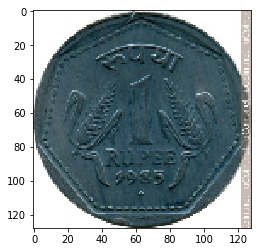

In [0]:
import matplotlib.pyplot as plt

plt.imshow(X[3000] , cmap='gray')

In [0]:
# randominzing the data
import random
combined = list(zip(X, Y_categorical))
random.shuffle(combined)
X[:], Y_categorical[:] = zip(*combined)

In [0]:
from keras.utils import to_categorical
Y = to_categorical(Y_categorical, num_classes = len(country_labels))

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [0]:
X_train = np.array(X_train)
X_test  = np.array(X_test)

In [0]:
print("X_train shape:{}".format(X_train.shape))
print("Y_train shape:{}".format(y_train.shape))
print("X_test shape:{}".format(X_test.shape))
print("Y_test shape:{}".format(y_test.shape))

X_train shape:(5644, 128, 128, 3)
Y_train shape:(5644, 32)
X_test shape:(1411, 128, 128, 3)
Y_test shape:(1411, 32)


# Model Building

In [0]:
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, BatchNormalization
from keras.layers import Dense, Conv2D, MaxPooling2D

In [0]:
def classifier():
  z = Input(shape=(128,128,3))
  x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128,128,3))(z)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.2)(x)

  x = Flatten()(x)
  x = Dense(512, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = Dense(128, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  output = Dense(32 , activation = 'softmax')(x)

  return Model(inputs = z , outputs = output )



In [0]:
import tensorflow as tf
coin_classifier = classifier()
coin_classifier.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

In [0]:
coin_classifier.fit(X_train, y_train , epochs = 30 , validation_split = 0.1 , batch_size = 16 , shuffle = True)

Train on 5079 samples, validate on 565 samples
Epoch 1/30
5079/5079 [==============================] - 48s 9ms/step - loss: 0.2643 - acc: 0.9238 - val_loss: 0.7617 - val_acc: 0.8425
Epoch 2/30
5079/5079 [==============================] - 48s 10ms/step - loss: 0.2193 - acc: 0.9370 - val_loss: 0.7155 - val_acc: 0.8354
Epoch 3/30
1552/5079 [========>.....................] - ETA: 32s - loss: 0.1833 - acc: 0.9504

In [126]:
loss, accuracy = coin_classifier.evaluate(X_test, y_test)

1411/1411 [==============================] - 2s 2ms/step


In [127]:
print("Test LOSS:{}".format(loss))
print("Test Accuracy:{}".format(accuracy*100))

Test LOSS:0.6790989882297535
Test Accuracy:85.1169383416017


In [0]:
y_pred = coin_classifier.predict(X_test)

In [0]:
y_pred_labels = []
y_test_labels = []
for y in y_pred:
  y_pred_labels.append(((np.where(y == y.max()))[0][0]))

for y in y_test:
  y_test_labels.append(((np.where(y == y.max()))[0][0]))

In [0]:
predictions = []
for label in y_pred_labels:
  predictions.append(reverse_label_dict[label])



# TESTING 

In [0]:
test_dir = "/content/gdrive/My Drive/test"

In [0]:
def get_labels(predictions):
  _ = []
  for y in predictions:
    idx = ((np.where(y == y.max()))[0][0])
    _.append(reverse_label_dict[idx])

  return _

In [104]:
test_results = {}
for img in tqdm(os.listdir(test_dir)):
  id = img.split('.')[0]
  img_path = os.path.join(test_dir,img)
  
  IMG = cv2.imread(img_path)
  IMG = cv2.resize(IMG,(128,128))
  IMG = np.array(IMG).astype('float32') / 255. 
  prediction = coin_classifier.predict(np.expand_dims(IMG, axis=0))
  label = (get_labels(prediction))[0]
  test_results[id] = label




100%|██████████| 1055/1055 [00:16<00:00, 64.09it/s]


In [0]:
test_images_array = np.array(test_images)
test_predictions = coin_classifier.predict(test_images_array)
labels = get_labels(test_predictions)

In [0]:
idx2labels = {i+1:labels[i] for i in range(len(labels))}

In [0]:
import csv
with open('/content/gdrive/My Drive/output_1.csv','w') as f:
  for key in test_results.keys():
    f.write("%s,%s\n"%(key,test_results[key]))

In [0]:
# saving the model
coin_classifier.save("/content/gdrive/My Drive/coin_classifier_85acc.h5")

In [105]:
test_results

{'58': 'new_zealand',
 '574': 'poland',
 '578': 'brazil',
 '568': 'usa',
 '569': 'mexico',
 '564': 'chile',
 '550': 'south_africa',
 '543': 'hungary',
 '580': 'czech_republic',
 '712': 'australia',
 '71': 'canada',
 '708': 'new_zealand',
 '673': 'malaysia',
 '660': 'turkey',
 '657': 'sweden',
 '655': 'australia',
 '645': 'australia',
 '650': 'russia',
 '640': 'sweden',
 '636': 'south_africa',
 '620': 'turkey',
 '622': 'denmark',
 '610': 'usa',
 '615': 'philippines',
 '611': 'south_korea',
 '6': 'brazil',
 '596': 'hungary',
 '565': 'poland',
 '717': 'poland',
 '697': 'new_zealand',
 '780': 'taiwan',
 '770': 'hungary',
 '753': 'russia',
 '746': 'denmark',
 '75': 'russia',
 '74': 'poland',
 '734': 'philippines',
 '729': 'czech_republic',
 '795': 'australia',
 '740': 'united_kingdom',
 '859': 'poland',
 '854': 'taiwan',
 '841': 'hong_kong',
 '832': 'spain',
 '829': 'united_kingdom',
 '815': 'poland',
 '813': 'singapore',
 '863': 'hungary',
 '872': 'denmark',
 '862': 'south_korea',
 '925': 